In [8]:
import torch
import os
import random
import pickle
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data.dataset import Dataset
import torchsummary
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [11]:
asd=33
f"{asd:06d}"

'000033'

In [12]:
for address, dirs, files in os.walk('../data/spectrograms/train/'):
    for file in files:
        if '000005.png' == file:
            print(address + '/' + file)

../data/spectrograms/train/train/Hip-Hop/000005.png


In [13]:
from torch.utils.data.dataset import Dataset
from PIL import Image

In [14]:
def image_loader(path):
    """Image Loader helper function."""
    return Image.open(path.rstrip("\n")).convert('RGB')


class TripletDataset(Dataset):
   
    def __init__(self, triplet_path, transform=None, train=True, loader=image_loader):
        """
        Image Loader Builder.
        Args:
            base_path: path to triplets.txt
            filenames_filename: text file with each line containing the path to an image e.g., `images/class1/sample.JPEG`
            triplets_filename: A text file with each line containing three images
            transform: torchvision.transforms
            loader: loader for each image
        """
#         self.base_path = base_path
        self.transform = transform
        self.loader = loader

        self.train_flag = train
        
        # load training data
        if self.train_flag:
            with open(triplet_path, 'rb') as f:
                triplets = pickle.load(f)
            self.triplets = triplets

        # load test data
#         else:
#             singletons = []
#             test_images = os.listdir(os.path.join(
#                 "../tiny-imagenet-200", "val", "images"))
#             for test_image in test_images:
#                 loaded_image = self.loader(os.path.join(
#                     "../tiny-imagenet-200", "val", "images", test_image))
#                 singletons.append(loaded_image)
#             self.singletons = singletons

    def __getitem__(self, index):
        """Get triplets in dataset."""
        # get trainig triplets
        if self.train_flag:
            path1, path2, path3 = self.triplets[index]
            q = self.loader(path1)
            p = self.loader(path2)
            n = self.loader(path3)
            if self.transform is not None:
                q = self.transform(q)
                p = self.transform(p)
                n = self.transform(n)
            return q, p, n

        # get test image
#         else:
#             img = self.singletons[index]
#             if self.transform is not None:
#                 img = self.transform(img)
#             return img

    def __len__(self):
        """Get the length of dataset."""
        if self.train_flag:
            return len(self.triplets)
#         else:
#             return len(self.singletons)

In [49]:
# Normalize training set together with augmentation
one_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.0069], [0.0033])
])


# Loading Tiny ImageNet dataset
trplt_path = '../pickles_for_git/triplets.p'
batch_szie = 32
trainset = TripletDataset(triplet_path=trplt_path, transform=one_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_szie, num_workers=8)

# testset = TripletImageLoader(
#     base_path=root, triplets_filename="", transform=transform_test, train=False)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=batch_size_test, num_workers=32)

In [50]:
len(trainset), len(trainloader)

(10000, 313)

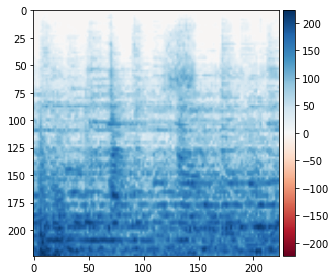

In [51]:
imshow(trainset[0][0].numpy().transpose(1,2,0))

In [82]:
def train(net, criterion, optimizer, scheduler, trainloader, epochs):
    """
    Training process.
    Args:
        net: Triplet Net
        criterion: TripletMarginLoss
        optimizer: SGD with momentum optimizer
        scheduler: scheduler
        trainloader: training set loader
        testloader: test set loader
        start_epoch: checkpoint saved epoch
        epochs: training epochs
        is_gpu: whether use GPU
    """
    print("==> Start training ...")

    net.train()
    for epoch in range(epochs):

        running_loss = 0.0
        for batch_idx, (data1, data2, data3) in enumerate(trainloader):

            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

            # wrap in torch.autograd.Variable
#             data1, data2, data3 = Variable(
#                 data1), Variable(data2), Variable(data3)

            # compute output and loss
            embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
            loss = criterion(embedded_a, embedded_p, embedded_n)

            # compute gradient and do optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

#             if batch_idx % 30 == 0:
#                 print("mini Batch Loss: {}".format(loss.data[0]))

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        print("Training Epoch: {0} | Loss: {1}".format(epoch+1, running_loss))

In [83]:
class EmbeddingNet(nn.Module):
    """EmbeddingNet using ResNet-101."""

    def __init__(self, resnet):
        """Initialize EmbeddingNet model."""
        super(EmbeddingNet, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs = resnet.fc.in_features
        self.fc1 = nn.Linear(num_ftrs, 4096)

    def forward(self, x):
        """Forward pass of EmbeddingNet."""
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out


class TripletNet(torch.nn.Module):
    """Triplet Network."""

    def __init__(self, embeddingnet):
        """Triplet Network Builder."""
        super(TripletNet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, a, p, n):
        """Forward pass."""
        # anchor
        embedded_a = self.embeddingnet(a)

        # positive examples
        embedded_p = self.embeddingnet(p)

        # negative examples
        embedded_n = self.embeddingnet(n)

        return embedded_a, embedded_p, embedded_n

In [84]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4[1:3].parameters():
    param.requires_grad = True
    
model = TripletNet(EmbeddingNet(resnet))

In [85]:
resnet.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [86]:
# torchsummary.summary(resnet.cuda(), (3, 128, 1248))

In [87]:
criterion = nn.TripletMarginLoss(margin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [88]:
model = model.to(device)

In [89]:
train(model, criterion, optimizer, scheduler, trainloader, 10)

==> Start training ...
Training Epoch: 1 | Loss: 1.0389121051984853
Training Epoch: 2 | Loss: 0.5624914677760091
Training Epoch: 3 | Loss: 0.45623405558613545
Training Epoch: 4 | Loss: 0.3909494469340998
Training Epoch: 5 | Loss: 0.34619138199395644
Training Epoch: 6 | Loss: 0.29906593158412664
Training Epoch: 7 | Loss: 0.2671711720502415
Training Epoch: 8 | Loss: 0.24457890228531992
Training Epoch: 9 | Loss: 0.22322932954508656
Training Epoch: 10 | Loss: 0.21670426428318024


In [90]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
train(model, criterion, optimizer, scheduler, trainloader, 5)

==> Start training ...
Training Epoch: 1 | Loss: 0.1400477899768101
Training Epoch: 2 | Loss: 0.12009271917442163
Training Epoch: 3 | Loss: 0.1017250813805638
Training Epoch: 4 | Loss: 0.09132591223183531
Training Epoch: 5 | Loss: 0.08372020019224277


In [91]:
torch.save(model, '../pickles_for_git/model_triplet.pth')